# Train temporal convolutional encoder-decoder model

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import cv2
import yaml
import os
import glob
import pickle as pkl
import sys
import importlib

In [2]:
# load yaml configuration file w/ keypoints dict ()
# assumes ..\ is root of project
# e.g. C:\MLprojects\motion_analysis\configs\config_analysis.yaml

# set up paths
ROOT_DIR = r"c:\MLprojects\human_motion_analysis"
CONFIG_DIR = "configs"

def load_config(config_name):
    with open(os.path.join(ROOT_DIR, CONFIG_DIR, config_name)) as file:
        config = yaml.full_load(file)
    return config

CONFIG_KEYPOINTS = load_config(r"keypoints.yaml")
CONFIG_EDGE_COLORS = load_config(r"edge_colors.yaml")
PARAMS = load_config(r"analysis_parameters.yaml")

# Confidence score to determine whether a keypoint prediction is reliable, e.g. for cropping algorithm during inference
KEYPOINT_THRESH_SCORE_CROP = load_config('analysis_parameters.yaml')['KEYPOINT_THRESH_SCORE_CROP']


In [3]:
os.chdir(ROOT_DIR)

In [4]:
# custom modules
from src.io import iomod
from src.inference import inference
from src.visualization import draw
from src.analysis import analysisphysics
from src.tests import testdraw, structshape

# Import plotting libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection # likely limited to draw module
import matplotlib.patches as patches
import seaborn as sns

# set sns
sns.set()

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display, Image

# checkpoint to start from loaded files

In [8]:
import fnmatch

# load all
with open(r"data\compiled\df_kpts", 'rb') as f:
  df_kpts = pkl.load(f)
with open(r"data\compiled\edge_vel_all", 'rb') as f:
  edge_vel_all = pkl.load(f)
with open(r"data\compiled\edge_length_all", 'rb') as f:
  edge_length_all = pkl.load(f)

infinityds_mp4paths = glob.glob("data\**\*.mp4", recursive=True)
armidx = [path for path in infinityds_mp4paths if "arm" in path]
curlidx = [path for path in infinityds_mp4paths if "curl" in path]

# concatenate all the paths
infinityds_mp4paths_armmotion = armidx + curlidx
infinityds_mp4paths_armmotion

# remove for now jitter or bilateral swapping or other poor quality issues (visualized with x-y plots below)
remove_pattern = ["*armraise*000004.mp4", "*armraise*000005.mp4", "*armraise*000006.mp4", "*armraise*000009.mp4", "*armraise*000013.mp4", "*armraise*000018.mp4", \
  "*armraise*000019.mp4", "*armraise*000033.mp4", "*armraise*000039.mp4", "*armraise*000042.mp4", "*armraise*000044.mp4", "*armraise*000066.mp4", "*armraise*000076.mp4", "*armraise*000094.mp4", "*armraise*000097.mp4", "*armraise*000099.mp4",
  "*armraise*000025.mp4", "*armraise*000044.mp4", "*armraise*000035.mp4", "*armraise*000026.mp4", "*armraise*000020.mp4", \
  "*curl*000001.mp4", "*curl*000022.mp4", "*curl*000025.mp4", "*curl*000034.mp4", "*curl*000035.mp4", "*curl*000043.mp4", "*curl*000049.mp4", \
  "*curl*000053.mp4", "*curl*000056.mp4", "*curl*000057.mp4", "*curl*000060.mp4", "*curl*000061.mp4", "*curl*000068.mp4", "*curl*000080.mp4", \
  "*curl*000080.mp4", "*curl*000082.mp4", "*curl*000090.mp4",]

# remove from list
infinityds_mp4paths_armmotion_rmv = [path for path in infinityds_mp4paths_armmotion \
  if not any(fnmatch.fnmatch(path, r) for r in remove_pattern)]

data_all, skippct, skippedpaths = iomod.compile_data_wrapper(infinityds_mp4paths_armmotion_rmv)

# remove skipped paths from infinityds_mp4paths_armmotion
infinityds_mp4paths_armmotion_rmv = [path for path in infinityds_mp4paths_armmotion_rmv if path not in skippedpaths]

FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000092.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000093.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000094.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000095.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000096.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000097.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000098.mp4
FileNotFoundError, Skipping data\infinity\InfinityAI_InfiniteRep_curl_v1.0\data\000099.mp4


# test out a couple classifiers for action recognition on images

In [9]:
edge_idx = 0
# list(CONFIG_KEYPOINTS)[edge_tuple[0]]
edge_tuple = list(CONFIG_EDGE_COLORS)[edge_idx]
print(f"{edge_tuple=}", structshape.getshape(edge_tuple))
kpt1_name = list(CONFIG_KEYPOINTS)[edge_tuple[0]]
print(f"{kpt1_name=}", structshape.getshape(kpt1_name))
kpt2_name = list(CONFIG_KEYPOINTS)[edge_tuple[1]]
print(f"{kpt2_name=}", structshape.getshape(kpt2_name))

edge_tuple=(0, 1) tuple of 2 int
kpt1_name='nose' str
kpt2_name='left_eye' str


In [10]:
# loop over all out_edges and compute pdist of each edge
edge_length_all = {}
edge_names = []
num_edges = 18

# map edge connectivity keys onto keypoint names for display
for edge_idx in range(num_edges):
  edge_tuple = list(CONFIG_EDGE_COLORS)[edge_idx]
  kpt1_name = list(CONFIG_KEYPOINTS)[edge_tuple[0]]
  kpt2_name = list(CONFIG_KEYPOINTS)[edge_tuple[1]]
  name = f"{kpt1_name}-{kpt2_name}"
  edge_names.append(name)


In [11]:
edge_names

['nose-left_eye',
 'nose-right_eye',
 'nose-left_shoulder',
 'nose-right_shoulder',
 'left_eye-left_ear',
 'right_eye-right_ear',
 'left_shoulder-right_shoulder',
 'left_shoulder-left_elbow',
 'left_shoulder-left_hip',
 'right_shoulder-right_elbow',
 'right_shoulder-right_hip',
 'left_elbow-left_wrist',
 'right_elbow-right_wrist',
 'left_hip-right_hip',
 'left_hip-left_knee',
 'right_hip-right_knee',
 'left_knee-left_ankle',
 'right_knee-right_ankle']

# sequence models

## train autoencoder and test on various anomaly datasets

In [24]:
from tensorflow import keras
from tensorflow.keras import layers

TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


In [25]:
# pose data
# load pickle files (from keras_tuner notebook 220603)
with open('data/compiled/df_edge_features_train.pkl', 'rb') as f:
  df_edge_features_train = pkl.load(f)
with open('data/compiled/df_edge_features_val.pkl', 'rb') as f:
  df_edge_features_val = pkl.load(f)
with open('data/compiled/df_edge_features_test.pkl', 'rb') as f:
  df_edge_features_test = pkl.load(f)

In [30]:
# pose data
x_train_pose = create_sequences(df_edge_features_train.iloc[:,48].values.reshape(-1, 1))
x_test_pose = create_sequences(df_edge_features_test.iloc[:,48].values.reshape(-1, 1))
x_val_pose = create_sequences(df_edge_features_val.iloc[:,48].values.reshape(-1, 1))

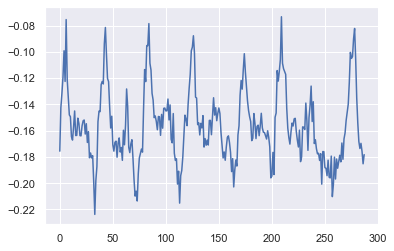

In [35]:
plt.plot(x_train_pose[4,:,:])

In [91]:
# pose - optional train
model = keras.Sequential(
    [
        layers.Input(shape=(x_train_pose.shape[1], x_train_pose.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


history = model.fit(
    x_train_pose,
    x_train_pose,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 288, 1)           

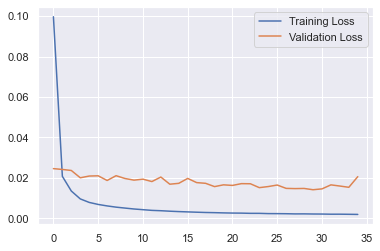

In [492]:
# pose
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [28]:
# vs load model
model = keras.models.load_model(r'models/model_joint_pose_only_right_elbow_right_wrist_start_x.h5')

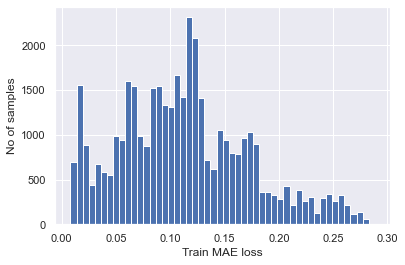

Reconstruction error threshold:  0.2883958637604431


In [36]:
# pose get MAE loss & threshold (max)
# note threshold drawn from training data, to be used on test data
x_train_pred_pose = model.predict(x_train_pose)
train_mae_loss_pose = np.mean(np.abs(x_train_pred_pose - x_train_pose), axis=1)

plt.hist(train_mae_loss_pose, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold_pose = np.max(train_mae_loss_pose) 
print("Reconstruction error threshold: ", threshold_pose)

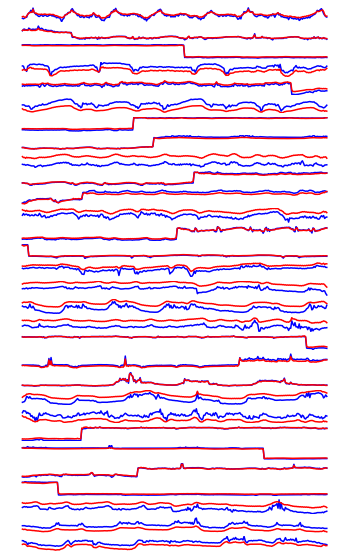

In [31]:
# pose - check train
plot_idxs = range(0, 30000, 1000)
subplot_idxs = [i + 1 for i in range(len(plot_idxs))]
x_train_pred_pose = model.predict(x_train_pose)

figure = plt.figure(figsize=(6,10))
for si, pi in zip(subplot_idxs, plot_idxs):
  plt.subplot(len(subplot_idxs),1, si)
  # plot_idx = plot_idxs[pi]
  plt.plot(x_train_pose[pi], color='blue')
  plt.plot(x_train_pred_pose[pi], color='red')
  plt.axis('off')


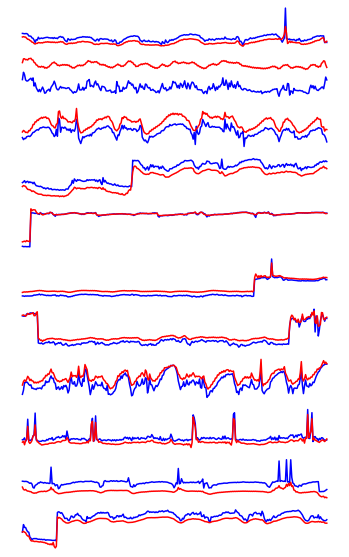

In [32]:
# pose - check test set
plot_idxs = range(0, 11000, 1000)
subplot_idxs = [i + 1 for i in range(len(plot_idxs))]
x_test_pred_pose = model.predict(x_test_pose)

figure = plt.figure(figsize=(6,10))
for si, pi in zip(subplot_idxs, plot_idxs):
  plt.subplot(len(subplot_idxs),1, si)
  # plot_idx = plot_idxs[pi]
  plt.plot(x_test_pose[pi], color='blue')
  plt.plot(x_test_pred_pose[pi], color='red')
  plt.axis('off')


Text(0, 0.5, 'No of samples')

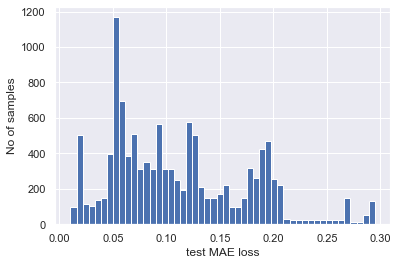

In [37]:
# pose
test_mae_loss_pose = np.mean(np.abs(x_test_pred_pose - x_test_pose), axis=1)
test_mae_loss_pose = test_mae_loss_pose.reshape((-1))

plt.hist(test_mae_loss_pose, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")

In [39]:
threshold_pose = 0.18

# Detect all the samples which are anomalies_pose.
anomalies_pose = test_mae_loss_pose > threshold_pose
print("Number of anomaly samples: ", np.sum(anomalies_pose))

Number of anomaly samples:  2300


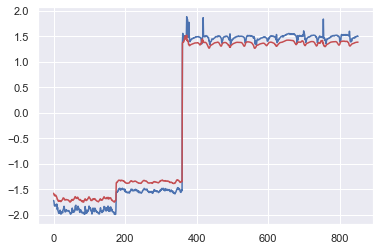

In [41]:
# pose
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices_pose = []
for data_idx in range(TIME_STEPS - 1, len(x_test_pose) - TIME_STEPS + 1):
    if np.all(anomalies_pose[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices_pose.append(data_idx)

plt.plot(x_test_pose[anomalous_data_indices_pose, 0, 0], color='b')
plt.plot(x_test_pred_pose[anomalous_data_indices_pose, 0, 0], color="r")
# plot all MAE > 0.18

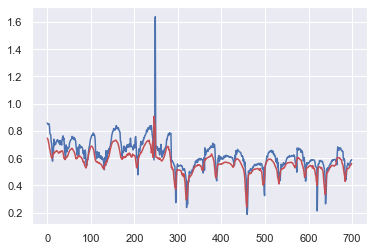

In [42]:
plt.plot(x_test_pose[0:700, 0, 0], color='b')
plt.plot(x_test_pred_pose[0:700, 0, 0], color="r")
# 287:664 have MAE > 0.18

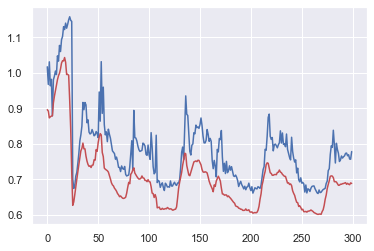

In [43]:
plt.plot(x_test_pose[2700:3000, 0, 0], color='b')
plt.plot(x_test_pred_pose[2700:3000, 0, 0], color="r")
# 2914:2924 have MAE > 0.18

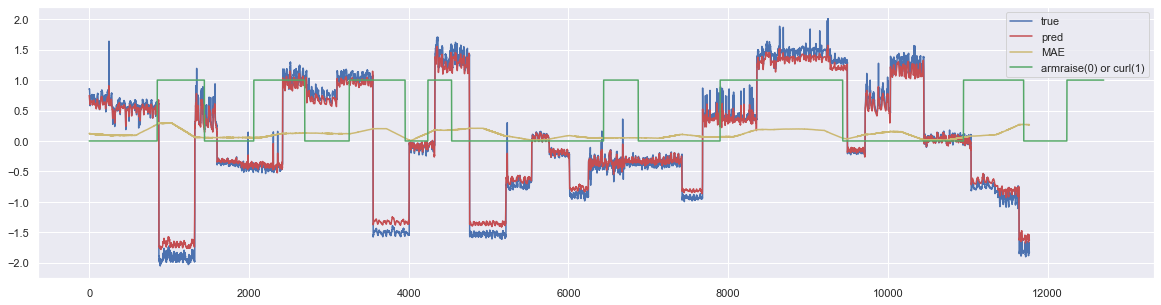

In [44]:
# post overall plot (step changes are different videos, concat for convenience here)
# reset sns

figure = plt.figure(figsize=(20,5))
plt.plot(x_test_pose[:,0,:], color='b')
plt.plot(x_test_pred_pose[:,0,:], color='r')
plt.plot(test_mae_loss_pose, color='y')
plt.plot(labels_test, color='g')
plt.legend(['true', 'pred', 'MAE', 'armraise(0) or curl(1)'])

In [45]:
len(labels_test), len(x_test_pred_pose)

(12704, 11773)

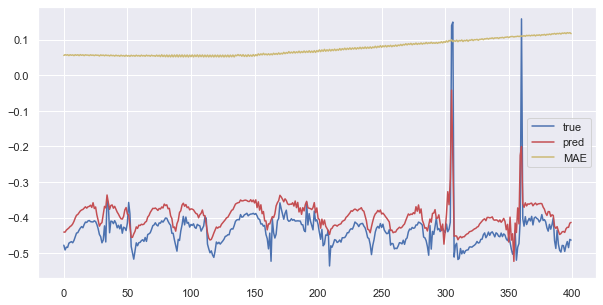

In [46]:
# this window mostly armraise
display_window_ix = np.arange(2000, 2400)

figure = plt.figure(figsize=(10,5))
plt.plot(x_test_pose[display_window_ix,0,:], color='b')
plt.plot(x_test_pred_pose[display_window_ix,0,:], color='r')
plt.plot(test_mae_loss_pose[display_window_ix], color='y')
plt.legend(['true', 'pred', 'MAE'])

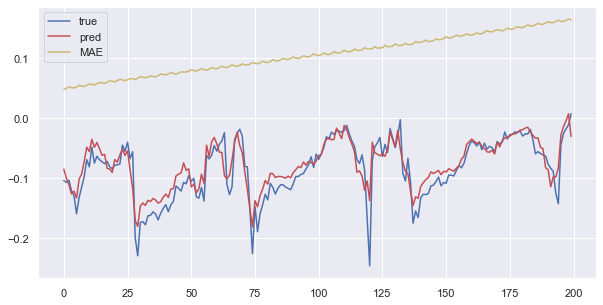

In [47]:
# this window mostly curl
display_window_ix = np.arange(4100, 4300)

figure = plt.figure(figsize=(10,5))
plt.plot(x_test_pose[display_window_ix,0,:], color='b')
plt.plot(x_test_pred_pose[display_window_ix,0,:], color='r')
plt.plot(test_mae_loss_pose[display_window_ix], color='y')
plt.legend(['true', 'pred', 'MAE'])

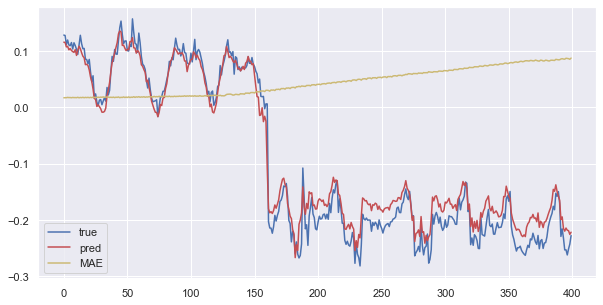

In [48]:
# this window mostly curl
display_window_ix = np.arange(5600, 6000)

figure = plt.figure(figsize=(10,5))
plt.plot(x_test_pose[display_window_ix,0,:], color='b')
plt.plot(x_test_pred_pose[display_window_ix,0,:], color='r')
plt.plot(test_mae_loss_pose[display_window_ix], color='y')
plt.legend(['true', 'pred', 'MAE'])

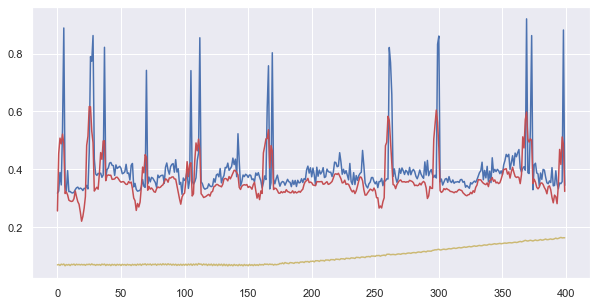

In [49]:
# this window mostly curl
display_window_ix = np.arange(7900, 8300)

figure = plt.figure(figsize=(10,5))
plt.plot(x_test_pose[display_window_ix,0,:], color='b')
plt.plot(x_test_pred_pose[display_window_ix,0,:], color='r')
plt.plot(test_mae_loss_pose[display_window_ix], color='y')

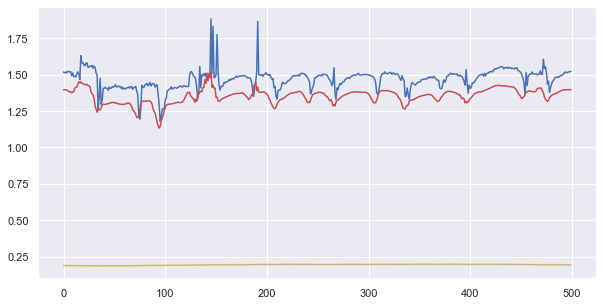

In [305]:
# this window mostly armraise
display_window_ix = np.arange(8500, 9000)

figure = plt.figure(figsize=(10,5))
plt.plot(x_test_pose[display_window_ix,0,:], color='b')
plt.plot(x_test_pred_pose[display_window_ix,0,:], color='r')
plt.plot(test_mae_loss_pose[display_window_ix], color='y')

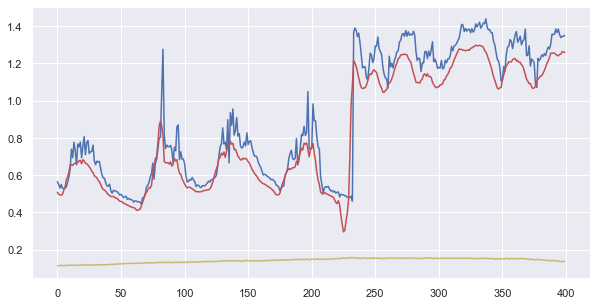

In [303]:
# this window mostly curl
display_window_ix = np.arange(9800, 10200)

figure = plt.figure(figsize=(10,5))
plt.plot(x_test_pose[display_window_ix,0,:], color='b')
plt.plot(x_test_pred_pose[display_window_ix,0,:], color='r')
plt.plot(test_mae_loss_pose[display_window_ix], color='y')

In [337]:
test_mae_loss_pose.shape

(11773,)

Text(0.5, 1.0, 'MAE')

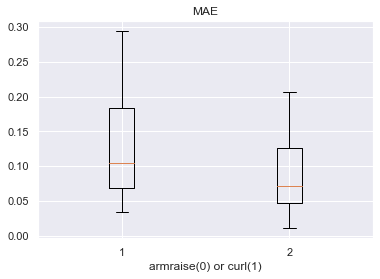

In [323]:
plt.boxplot([test_mae_loss_pose[np.array(labels_test_trim) == 0], test_mae_loss_pose[np.array(labels_test_trim) == 1]])
plt.xlabel("armraise(0) or curl(1)")
plt.title("MAE")

In [332]:
name_combinations

['nose-left_eye-start_x',
 'nose-left_eye-start_y',
 'nose-left_eye-end_x',
 'nose-left_eye-end_y',
 'nose-right_eye-start_x',
 'nose-right_eye-start_y',
 'nose-right_eye-end_x',
 'nose-right_eye-end_y',
 'nose-left_shoulder-start_x',
 'nose-left_shoulder-start_y',
 'nose-left_shoulder-end_x',
 'nose-left_shoulder-end_y',
 'nose-right_shoulder-start_x',
 'nose-right_shoulder-start_y',
 'nose-right_shoulder-end_x',
 'nose-right_shoulder-end_y',
 'left_eye-left_ear-start_x',
 'left_eye-left_ear-start_y',
 'left_eye-left_ear-end_x',
 'left_eye-left_ear-end_y',
 'right_eye-right_ear-start_x',
 'right_eye-right_ear-start_y',
 'right_eye-right_ear-end_x',
 'right_eye-right_ear-end_y',
 'left_shoulder-right_shoulder-start_x',
 'left_shoulder-right_shoulder-start_y',
 'left_shoulder-right_shoulder-end_x',
 'left_shoulder-right_shoulder-end_y',
 'left_shoulder-left_elbow-start_x',
 'left_shoulder-left_elbow-start_y',
 'left_shoulder-left_elbow-end_x',
 'left_shoulder-left_elbow-end_y',
 'left_s

C:\Users\Windows\AppData\Local\Temp\ipykernel_11008\866226083.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1 = plt.figure(figsize=(6,10))


TypeError: list indices must be integers or slices, not range

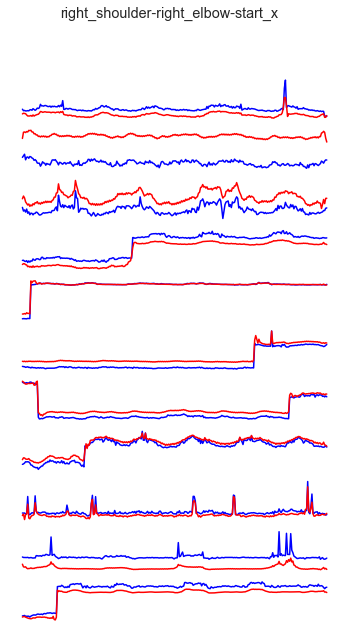

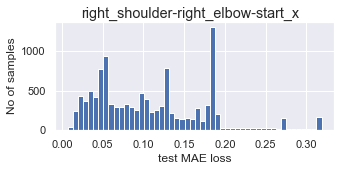

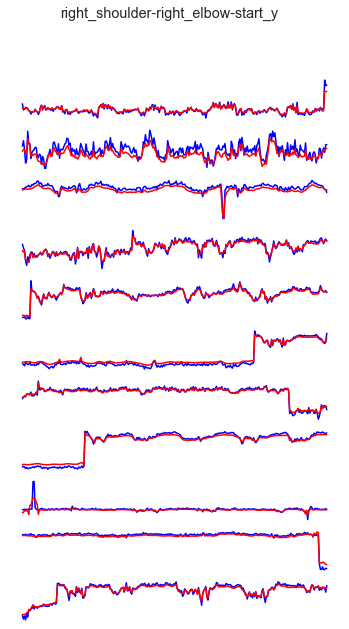

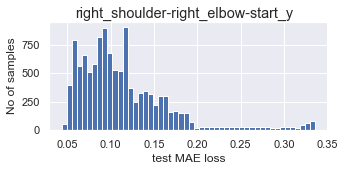

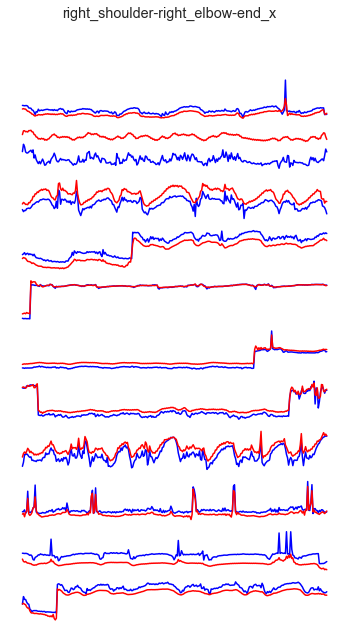

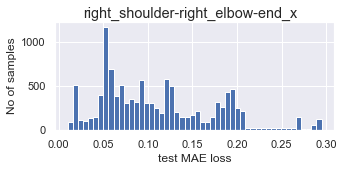

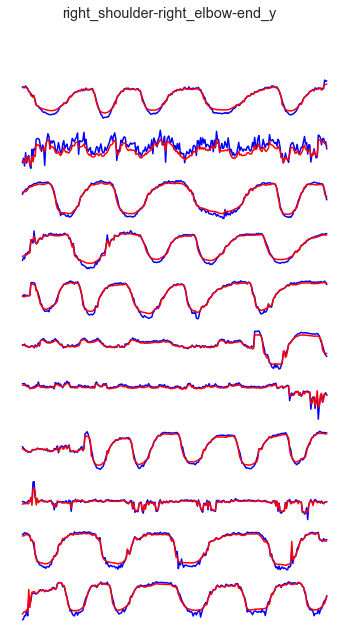

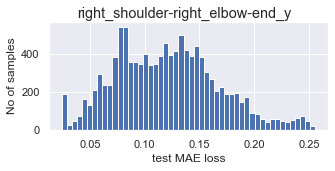

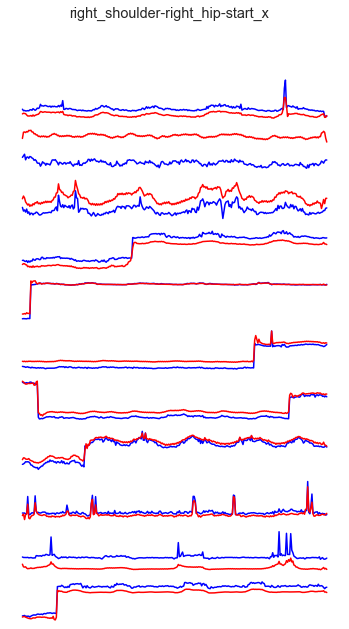

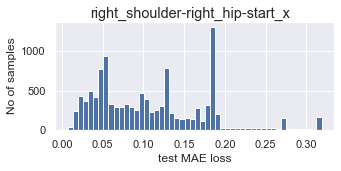

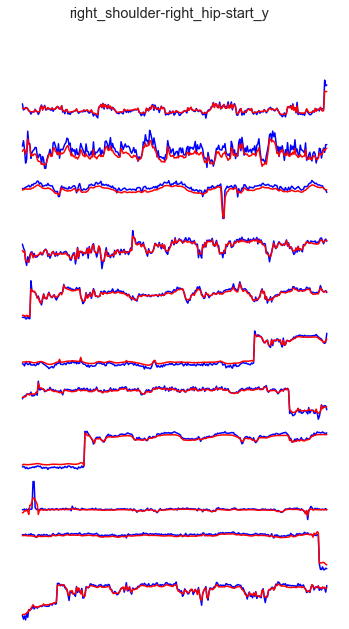

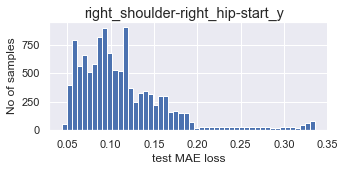

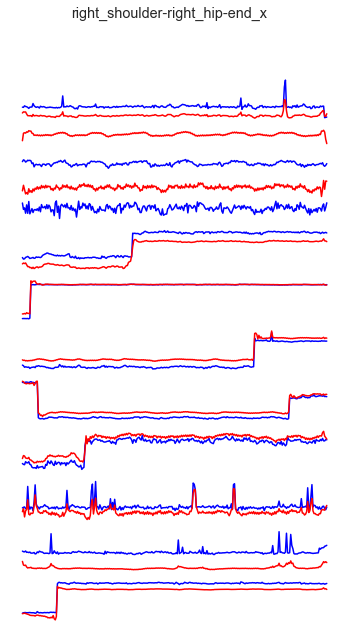

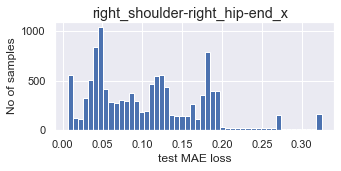

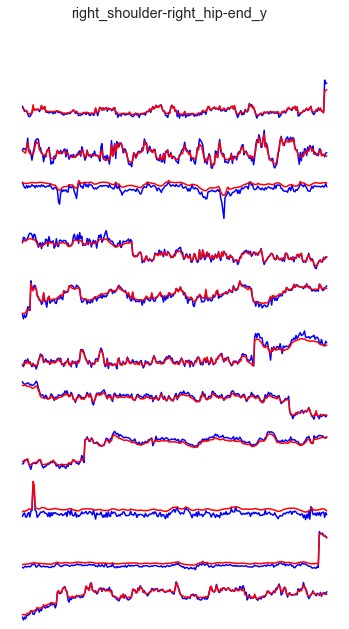

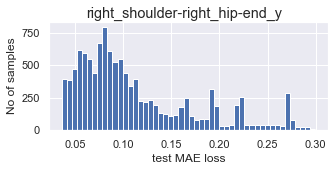

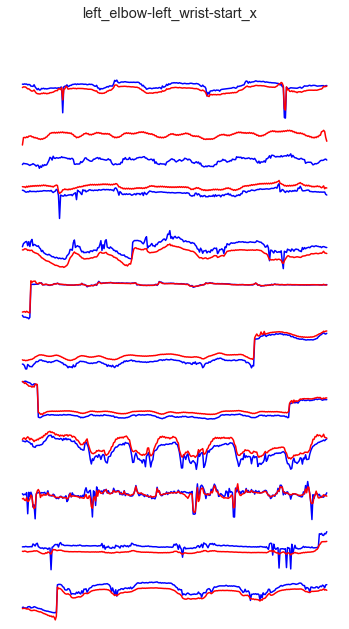

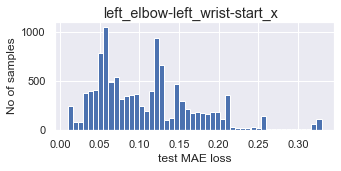

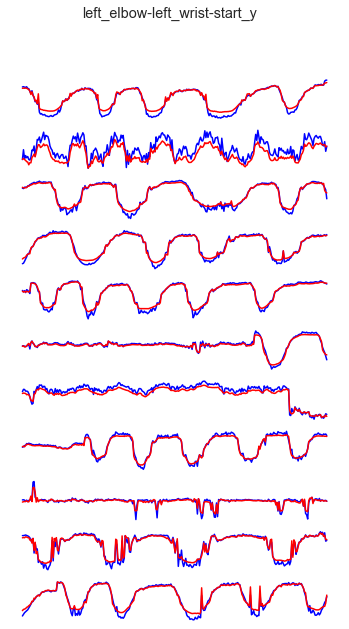

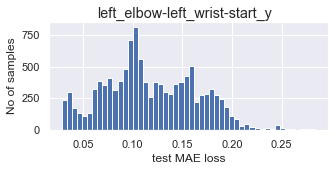

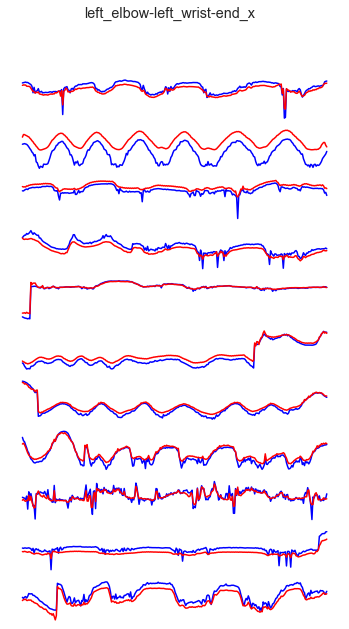

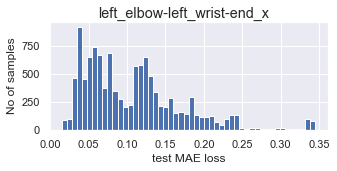

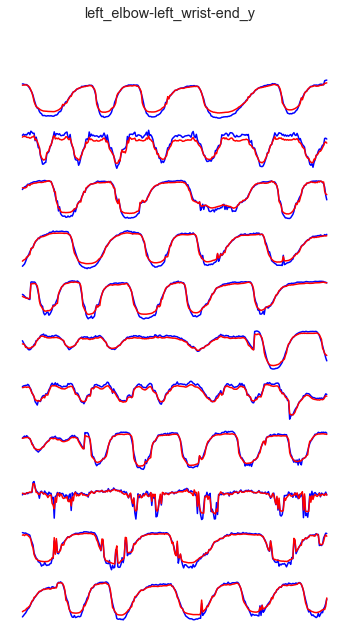

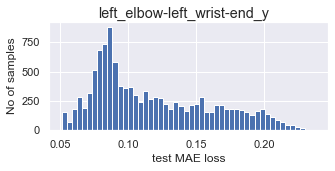

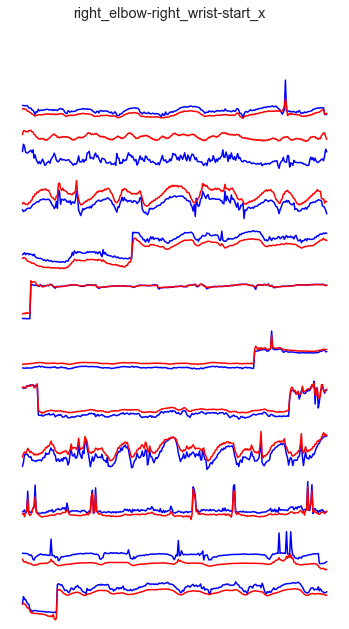

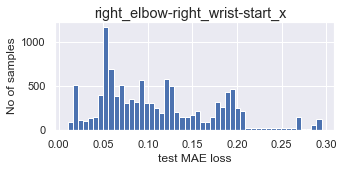

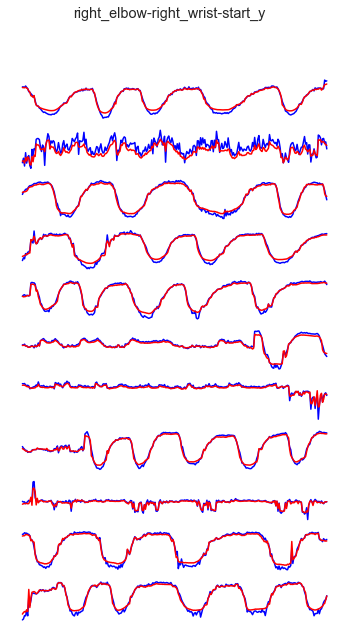

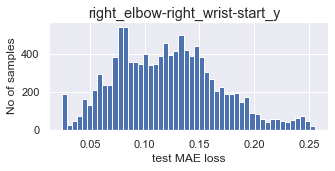

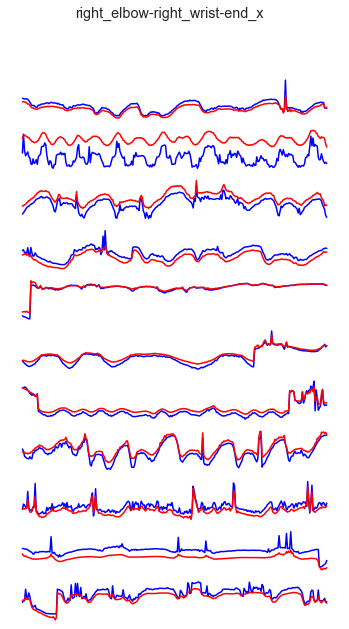

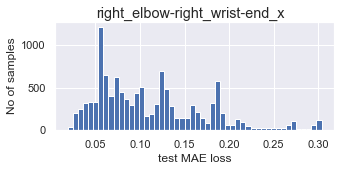

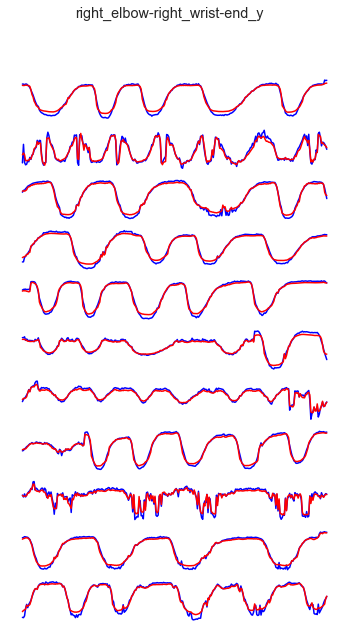

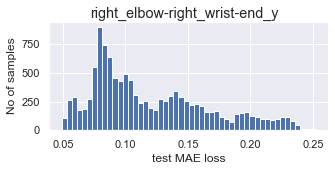

In [338]:
# pose - test on other joint positions (only trained on one joint)

analyze_jt_idx = range(36, 52)
plot_idxs = range(0, 11000, 1000)
MAE_cum = []

for jt_idx in analyze_jt_idx:

  x_test_pose = create_sequences(df_edge_features_test.iloc[:,jt_idx].values.reshape(-1, 1))
  x_test_pred_pose = model.predict(x_test_pose)

  subplot_idxs = [i + 1 for i in range(len(plot_idxs))]

  fig1 = plt.figure(figsize=(6,10))
  fig1.suptitle(name_combinations[jt_idx])

  for si, pi in zip(subplot_idxs, plot_idxs):
    plt.subplot(len(subplot_idxs),1, si)
    plt.plot(x_test_pose[pi], color='blue')
    plt.plot(x_test_pred_pose[pi], color='red')
    plt.axis('off')

  fig2 = plt.figure(figsize=(5,2))
  fig2.suptitle(name_combinations[jt_idx])

  # Get test MAE loss.
  test_mae_loss_pose = np.mean(np.abs(x_test_pred_pose - x_test_pose), axis=1)
  test_mae_loss_pose = test_mae_loss_pose.reshape((-1))

  plt.hist(test_mae_loss_pose, bins=50)
  plt.xlabel("test MAE loss")
  plt.ylabel("No of samples")

  MAE_cum.append(test_mae_loss_pose)

plt.boxplot(name_combinations[analyze_jt_idx], MAE_cum)
plt.xlabel("joint")
plt.title("MAE")

In [354]:
list(itemgetter(*analyze_jt_idx)(name_combinations))

['right_shoulder-right_elbow-start_x',
 'right_shoulder-right_elbow-start_y',
 'right_shoulder-right_elbow-end_x',
 'right_shoulder-right_elbow-end_y',
 'right_shoulder-right_hip-start_x',
 'right_shoulder-right_hip-start_y',
 'right_shoulder-right_hip-end_x',
 'right_shoulder-right_hip-end_y',
 'left_elbow-left_wrist-start_x',
 'left_elbow-left_wrist-start_y',
 'left_elbow-left_wrist-end_x',
 'left_elbow-left_wrist-end_y',
 'right_elbow-right_wrist-start_x',
 'right_elbow-right_wrist-start_y',
 'right_elbow-right_wrist-end_x',
 'right_elbow-right_wrist-end_y']

In [394]:
name_combinations[48]

'right_elbow-right_wrist-start_x'

Text(0.5, 0, 'MAE')

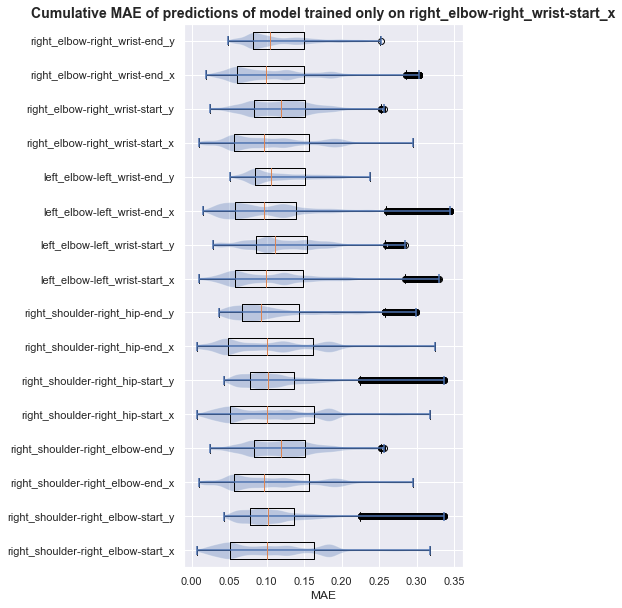

In [424]:
from operator import itemgetter

# plot MAE for all
fig = plt.figure(figsize=(5,10))
plt.boxplot(MAE_cum, labels=list(itemgetter(*analyze_jt_idx)(name_combinations)), vert=False)
plt.violinplot(MAE_cum, vert=False)

plt.title("Cumulative MAE of predictions of model trained only on right_elbow-right_wrist-start_x", fontsize=14, fontweight='bold')
plt.xlabel("MAE")


so may be worth exploring further - seems like same model able to predict outliers on different types of data - numenta data, new video sequence start stepchange, within video sequence spikes and smoothing, and different types of movements and joints

- improve training dataset quality (remove jitter, stepchanges)
- simplify to test one type of movement
- look for more separation in clusters of more accurate MAE vs. outlier MAE

In [495]:
# save model
model.save(r'models/model_joint_pose_only_right_elbow_right_wrist_start_x.h5')

set aside for now (unclear keypoint & image ids?)

In [ ]:
# import json

# # load json files from paths
# for path in train_paths[1:2]:
#   path_json = path.replace("mp4", "json")
#   with open(path_json, 'r') as f:
#     data = json.load(f)

#   # extract data
#   for fri in range(len(data)):
#     data['annotations'][fri]['armature_keypoints']
#     for kpt in CONFIG_KEYPOINTS.keys():
#       data['annotations'][fri]['armature_keypoints'][kpt]

# # load data annotations into dataframe
# # data['annotations'][0]['armature_keypoints']

# # extract data
# kpts_extracted = []
# for fri in range(len(data['annotations'])):
#   try:
#     armkpts = data['annotations'][fri]['armature_keypoints']
#     kpts_extracted_fri = []
#     for kpt, val in armkpts.items():
#       # kpts_extracted_fri.append(val)
#       kpts_extracted_fri.append((armkpts[kpt]["x"], armkpts[kpt]["y"]))
#       kpts_extracted.append(kpts_extracted_fri)
#   except KeyError:
#     print(f"KeyError: {kpt} {fri}")
# for i, k in enumerate(CONFIG_KEYPOINTS.keys()):
#   print(f"{i} {k}")
# path = train_paths[1]
# data_all['out_keypoints'][path].shape
# # vertically concatenate
# kpts_extracted = np.concatenate(kpts_extracted)
